<a href="https://colab.research.google.com/github/AndreaKarlova/censored_regressors/blob/main/notebooks/synthetically_censored_2D_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uq gpytorch

In [2]:
!pip install -Uq botorch

In [3]:
!rm -rf censored_regressors
!git clone https://github.com/AndreaKarlova/censored_regressors.git

Cloning into 'censored_regressors'...
remote: Enumerating objects: 228, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 228 (delta 23), reused 37 (delta 16), pack-reused 177 (from 1)
Receiving objects: 100% (228/228), 35.24 MiB | 19.92 MiB/s, done.
Resolving deltas: 100% (107/107), done.


In [4]:
import tqdm
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
from matplotlib import pyplot as plt

In [5]:
import math
from numbers import Number, Real

import botorch
import torch
from torch.distributions import constraints
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import _standard_normal, broadcast_all

import importlib
from censored_regressors.src.censored_normal import CensoredNormal
from censored_regressors.src.censored_likelihood import CensoredGaussianLikelihood, CensoredGaussianLikelihoodAnalytic, CensoredGaussianLikelihoodMathematica

In [6]:
import warnings
from typing import Any

import torch
from linear_operator.operators import LinearOperator, ZeroLinearOperator
from torch import Tensor
from torch.distributions import Distribution, Normal

from gpytorch.constraints import Interval
from gpytorch.distributions import base_distributions, MultivariateNormal
from gpytorch.priors import Prior
from gpytorch.utils.warnings import GPInputWarning
from gpytorch.likelihoods.likelihood import _Likelihood, _OneDimensionalLikelihood

In [7]:
import pandas as pd
from gpytorch.models import ApproximateGP # handles basic variational inference
from gpytorch.variational import MeanFieldVariationalDistribution, CholeskyVariationalDistribution # distribution of the approximation q(f)
from gpytorch.variational import VariationalStrategy # use when larger sample - transform q(u) to q(f) over inducing points
from gpytorch.variational._variational_distribution import _VariationalDistribution
import torch
from linear_operator.operators import CholLinearOperator, TriangularLinearOperator
from gpytorch.distributions import MultivariateNormal


class CholeskyVariationalDistribution(_VariationalDistribution):
    """
    A :obj:`~gpytorch.variational._VariationalDistribution` that is defined to be a multivariate normal distribution
    with a full covariance matrix.

    The most common way this distribution is defined is to parameterize it in terms of a mean vector and a covariance
    matrix. In order to ensure that the covariance matrix remains positive definite, we only consider the lower
    triangle.

    :param num_inducing_points: Size of the variational distribution. This implies that the variational mean
        should be this size, and the variational covariance matrix should have this many rows and columns.
    :param batch_shape: Specifies an optional batch size
        for the variational parameters. This is useful for example when doing additive variational inference.
    :param mean_init_std: (Default: 1e-3) Standard deviation of gaussian noise to add to the mean initialization.
    """

    def __init__(
        self,
        num_inducing_points: int,
        batch_shape: torch.Size = torch.Size([]),
        mean_init_std: float = 1e-3,
        dtype: torch.dtype = torch.float32,
        **kwargs,
    ):
        super().__init__(num_inducing_points=num_inducing_points, batch_shape=batch_shape, mean_init_std=mean_init_std)
        mean_init = torch.zeros(num_inducing_points, dtype=dtype)
        covar_init = torch.eye(num_inducing_points, num_inducing_points, dtype=dtype)
        mean_init = mean_init.repeat(*batch_shape, 1)
        covar_init = covar_init.repeat(*batch_shape, 1, 1)

        self.register_parameter(name="variational_mean", parameter=torch.nn.Parameter(mean_init))
        self.register_parameter(name="chol_variational_covar", parameter=torch.nn.Parameter(covar_init))

    def forward(self) -> MultivariateNormal:
        chol_variational_covar = self.chol_variational_covar
        dtype = chol_variational_covar.dtype
        device = chol_variational_covar.device

        # First make the cholesky factor is upper triangular
        lower_mask = torch.ones(self.chol_variational_covar.shape[-2:], dtype=dtype, device=device).tril(0)
        chol_variational_covar = TriangularLinearOperator(chol_variational_covar.mul(lower_mask))

        # Now construct the actual matrix
        variational_covar = CholLinearOperator(chol_variational_covar)
        return MultivariateNormal(self.variational_mean, variational_covar)

    def initialize_variational_distribution(self, prior_dist: MultivariateNormal) -> None:
        self.variational_mean.data.copy_(prior_dist.mean)
        self.variational_mean.data.add_(torch.randn_like(prior_dist.mean), alpha=self.mean_init_std)
        self.chol_variational_covar.data.copy_(prior_dist.lazy_covariance_matrix.cholesky().to_dense())



class GPModel(ApproximateGP):
    def __init__(self, inducing_points, covariance_type='cholesky', kernel='rbf', learn_inducing_locations=False, dtype=torch.float32):
        # defines approximation
        if covariance_type == 'cholesky':
          variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0), dtype=dtype)
        elif covariance_type == 'mean_field':
          variational_distribution = MeanFieldVariationalDistribution(inducing_points.size(0))
        else:
          raise ValueError("Unknown covariance_type.")
        variational_strategy = VariationalStrategy(self, inducing_points,
                                                   variational_distribution,
                                                   learn_inducing_locations=learn_inducing_locations)
        super(GPModel, self).__init__(variational_strategy)
        # defines the GP prior
        self.mean_module = gpytorch.means.ConstantMean()
        if kernel == 'rbf':
          self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        elif kernel == 'matern':
          self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

    def forward(self, x):
        # for line in traceback.format_stack():
        #   print(line.strip())
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



# Synthetic Dataset 1: Griewank 2D

The dataset has a global minimum at x=(0, 0) at which point y=0

In [8]:
synthetic_test_fn = botorch.test_functions.synthetic.Griewank(noise_std=1)

In [9]:
np.random.seed(1234)
x = np.random.uniform(low=-600, high=600, size=(200, 2))
x[:2]

array([[-370.17665955,  146.53052525],
       [ -74.72671319,  342.43030046]])

In [10]:
x = torch.tensor(x, dtype=torch.float64)
y_latent = synthetic_test_fn(x)

In [11]:
MIN_VALUE, MAX_VALUE = 20, 100
y = y_latent.clone()
y[y > MAX_VALUE] = MAX_VALUE
y[y < MIN_VALUE] = MIN_VALUE
y

tensor([ 40.7542,  32.5900,  48.2188,  53.1086, 100.0000,  20.0000,  29.6487,
         20.0000,  85.7331,  81.1905,  20.0000,  73.0258,  76.6012,  35.8174,
         20.0000,  47.9894,  77.9251,  34.1469,  95.7779,  62.4652, 100.0000,
         87.2386,  20.0000,  79.4717,  20.0000,  62.0252,  89.3674,  66.6037,
        100.0000, 100.0000,  22.6312,  33.2720,  77.0062,  84.3598, 100.0000,
         24.8912,  57.2507,  86.0978,  20.0000, 100.0000,  20.0000,  69.0156,
         58.9533,  62.3680,  20.0000,  46.7801,  75.8319,  20.0000,  37.4465,
         82.4097,  42.4873,  33.4062, 100.0000,  83.1372, 100.0000,  44.8695,
         65.1075,  74.2740,  47.2519,  72.5042,  77.8639,  32.0756,  59.1903,
         20.0000, 100.0000,  20.0000,  61.6613,  88.4084, 100.0000,  20.0000,
        100.0000,  85.2852,  72.9415,  65.8290,  20.7901,  91.0696,  78.3775,
         56.8149,  86.1750,  20.0000,  48.0518, 100.0000, 100.0000,  20.0000,
        100.0000,  20.0000,  62.0639,  47.8612,  39.2826,  44.66

In [12]:
x_test = np.meshgrid(np.linspace(-600, 600, 100), np.linspace(-600, 600, 100))
x_test = np.stack(x_test, axis=-1).reshape((-1, 2))

In [13]:
x_test = torch.tensor(x_test, dtype=torch.float64)
y_latent_test = synthetic_test_fn(x_test)
y_test = y_latent_test.clone()
y_test[y_test > MAX_VALUE] = MAX_VALUE
y_test[y_test < MIN_VALUE] = MIN_VALUE

Plot histograms of uncensored and censored targets `y`

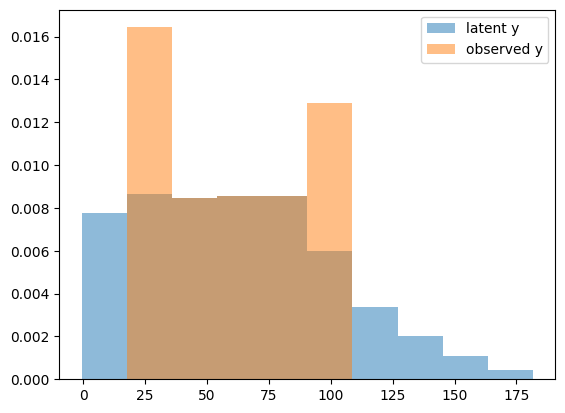

In [14]:
_, bins, _ = plt.hist(y_latent_test, alpha=0.5, label='latent y', density=True)
plt.hist(y_test, alpha=0.5, label='observed y', density=True, bins=bins)
plt.legend()

MAE of predicting mean

In [15]:
(y_test - y_test.mean()).abs().mean()

tensor(26.3508, dtype=torch.float64)

## Censored Regressor

In [16]:
censored_model = GPModel(inducing_points=x, covariance_type='cholesky', kernel='matern', learn_inducing_locations=True, dtype=torch.float64)
censored_likelihood = CensoredGaussianLikelihoodAnalytic(low=MIN_VALUE, high=MAX_VALUE,
                                                         alpha=1., gamma=1., dzeta=1.)

if torch.cuda.is_available():
    x = x.cuda()
    y = y.cuda()
    censored_model = censored_model.cuda()
    censored_likelihood = censored_likelihood.cuda()

lmbd = 2 # lmbd in [1,10], 1 -> very linear, 10 -> very non-linear
kappa = 20 # kappa in [2,100], this is the signal to noise ratio. kappa = 2 -> signal = 2*noise
censored_model.covar_module.base_kernel.initialize(lengthscale=x.std()/lmbd)
censored_model.covar_module.initialize(outputscale=y.var());
censored_model.mean_module.initialize(constant=y.mean())
censored_likelihood.noise.initialize(noise=(y.std()/kappa).square());

censored_model.train()
censored_likelihood.train()
censored_model.train_inputs = (x,)
censored_model.train_targets = y
mll = gpytorch.mlls.VariationalELBO(censored_likelihood, censored_model, num_data=y.size(0))
# res = botorch.fit.fit_gpytorch_mll_torch(mll)
res = botorch.fit.fit_gpytorch_mll_scipy(mll, options={'gtol': 1e-7, 'ftol': 1e-7})
print(res)


OptimizationResult(step=1027, fval=1.8340979355523654, status=<OptimizationStatus.SUCCESS: 2>, runtime=81.41350444099953, message='CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH')


### Evaluate on test data

In [ ]:
censored_model.eval()
censored_likelihood.eval()
with gpytorch.settings.num_likelihood_samples(200):
  censored_posterior_f = censored_model(x_test)
  censored_posterior_y = censored_likelihood(censored_posterior_f)
# expected_y_pred = censored_posterior_y.sample_n(200).mean([0,1])
# print('Log prob of training data:', censored_posterior_y.log_prob(y).mean())
# print('MAE of training data (censored):', (expected_y_pred - y_test).abs().mean())
print('MAE of latent data:', (censored_posterior_f.loc - y_latent_test).abs().mean())

## Uncensored Regressor

In [19]:
uncensored_model = GPModel(inducing_points=x, covariance_type='cholesky', learn_inducing_locations=True, dtype=torch.float64)
uncensored_model.covar_module.base_kernel.initialize(lengthscale=x.std()/lmbd)
uncensored_model.covar_module.initialize(outputscale=y.var());
uncensored_model.mean_module.initialize(constant=y.mean())
uncensored_likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.NormalPrior(loc=(y.std()/kappa).square(), scale=1))

if torch.cuda.is_available():
    uncensored_model = uncensored_model.cuda()
    uncensored_likelihood = uncensored_likelihood.cuda()


uncensored_model.train()
uncensored_likelihood.train()
uncensored_model.train_inputs = (x,)
uncensored_model.train_targets = y
uncensored_mll = gpytorch.mlls.VariationalELBO(uncensored_likelihood, uncensored_model, num_data=y.size(0))
# uncensored_res = botorch.fit.fit_gpytorch_mll_torch(uncensored_mll)
uncensored_res = botorch.fit.fit_gpytorch_mll_scipy(uncensored_mll)
print(uncensored_res)

OptimizationResult(step=2211, fval=2.3902189817704955, status=<OptimizationStatus.SUCCESS: 2>, runtime=149.5048328009998, message='CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH')


### Evaluate on test data

In [20]:
uncensored_model.eval()
uncensored_likelihood.eval()

uncensored_posterior_f = uncensored_model(x_test)
# uncensored_posterior_y = uncensored_likelihood(uncensored_posterior_f)

# print('MAE of training data (censored):', (uncensored_posterior_y.loc - y_test).abs().mean())
print('MAE of latent data:', (uncensored_posterior_f.loc - y_latent_test).abs().mean())

MAE of latent data: tensor(6.6512, dtype=torch.float64, grad_fn=<MeanBackward0>)


Scatter plots wrt latent `y`

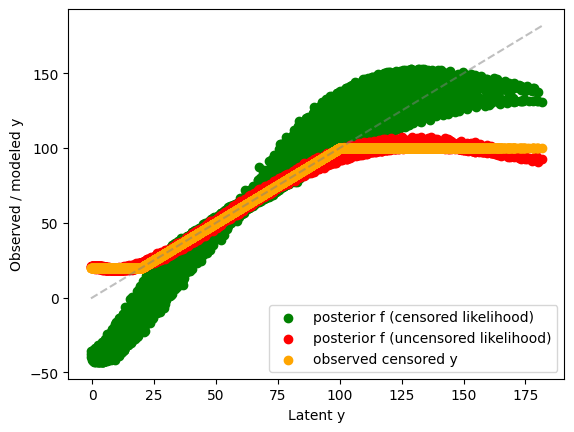

In [21]:
plt.scatter(y_latent_test.detach(), censored_posterior_f.loc.detach(), label='posterior f (censored likelihood)', color='green')
plt.scatter(y_latent_test.detach(), uncensored_posterior_f.loc.detach(), label='posterior f (uncensored likelihood)', color='red')
plt.scatter(y_latent_test.detach(), y_test.detach(), label='observed censored y', color='orange')
y_equals_x_grid = np.linspace(y_latent_test.min(), y_latent_test.max(), num=1000)
plt.plot(y_equals_x_grid, y_equals_x_grid, alpha=0.5, linestyle='--', color='grey')
plt.xlabel("Latent y")
plt.ylabel("Observed / modeled y")
plt.legend()

Function plots wrt x_0 and x_1

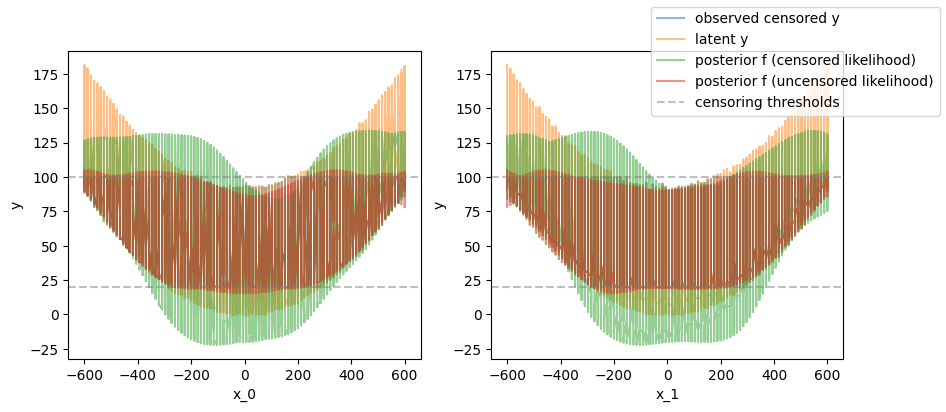

In [49]:
x_dims = x.shape[-1]
fig, axes = plt.subplots(ncols=x_dims, figsize=(5*x_dims, 4))
for i, ax in enumerate(axes):
  sorted_idx = np.argsort(x_test[:, i])
  x_grid = x_test[sorted_idx, i]
  ax.plot(x_grid, y_test[sorted_idx], label='observed censored y', alpha=0.5)
  ax.plot(x_grid, y_latent_test[sorted_idx], label='latent y', alpha=0.5)
  ax.plot(x_grid, censored_posterior_f.loc.detach()[sorted_idx], label='posterior f (censored likelihood)', alpha=0.5)
  ax.plot(x_grid, uncensored_posterior_f.loc.detach()[sorted_idx], label='posterior f (uncensored likelihood)', alpha=0.5)
  ax.axhline(MIN_VALUE, color='grey', linestyle='--', alpha=0.5)
  ax.axhline(MAX_VALUE, color='grey', linestyle='--', alpha=0.5, label='censoring thresholds')
  ax.set_xlabel('x_%d' % i)
  ax.set_ylabel('y')
fig.legend(*ax.get_legend_handles_labels())

3D function plot

<ipython-input-77-760ab5bd86a8>:11: RuntimeWarning: invalid value encountered in log10
  ax.plot_surface(x_test[:, 0].reshape((100, 100)), x_test[:, 1].reshape((100, 100)), np.log10(y_latent_test.reshape((100, 100))),


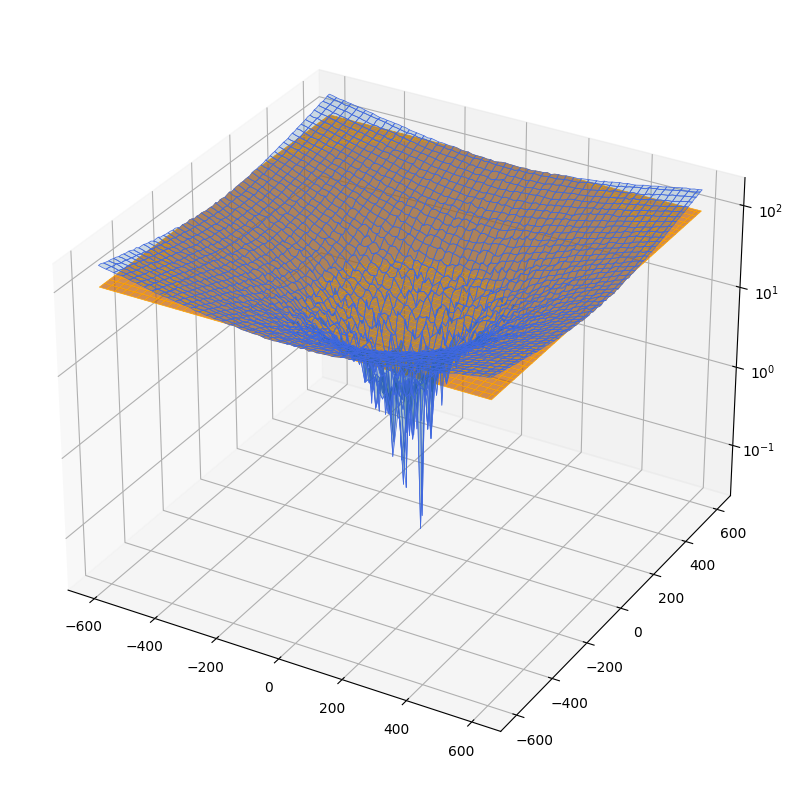

In [77]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')

def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"

# Plot the 3D surface
ax.plot_surface(x_test[:, 0].reshape((100, 100)), x_test[:, 1].reshape((100, 100)), np.log10(y_latent_test.reshape((100, 100))),
                edgecolor='royalblue', lw=0.5, rstride=2, cstride=2, label='latent y',
                alpha=0.2)
ax.plot_surface(x_test[:, 0].reshape((100, 100)), x_test[:, 1].reshape((100, 100)), np.log10(y_test.reshape((100, 100))),
                edgecolor='orange', lw=0.5, rstride=2, cstride=2, label='observed y',
                alpha=0.7)
ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.zaxis.set_major_locator(mticker.MaxNLocator(integer=True))

<ipython-input-81-5d8571c1f483>:11: RuntimeWarning: invalid value encountered in log10
  ax.plot_surface(x_test[:, 0].reshape((100, 100)), x_test[:, 1].reshape((100, 100)), np.log10(y_latent_test.reshape((100, 100))),
<ipython-input-81-5d8571c1f483>:17: RuntimeWarning: invalid value encountered in log10
  ax.plot_surface(x_test[:, 0].reshape((100, 100)), x_test[:, 1].reshape((100, 100)), np.log10(censored_posterior_f.loc.detach().reshape((100, 100))),


Text(0.5, 0.92, 'Legend:\nblue = latent y\norange = observed censored y\ngreen = posterior means (censored lik.)\nred = posterior means (uncensored lik.)')

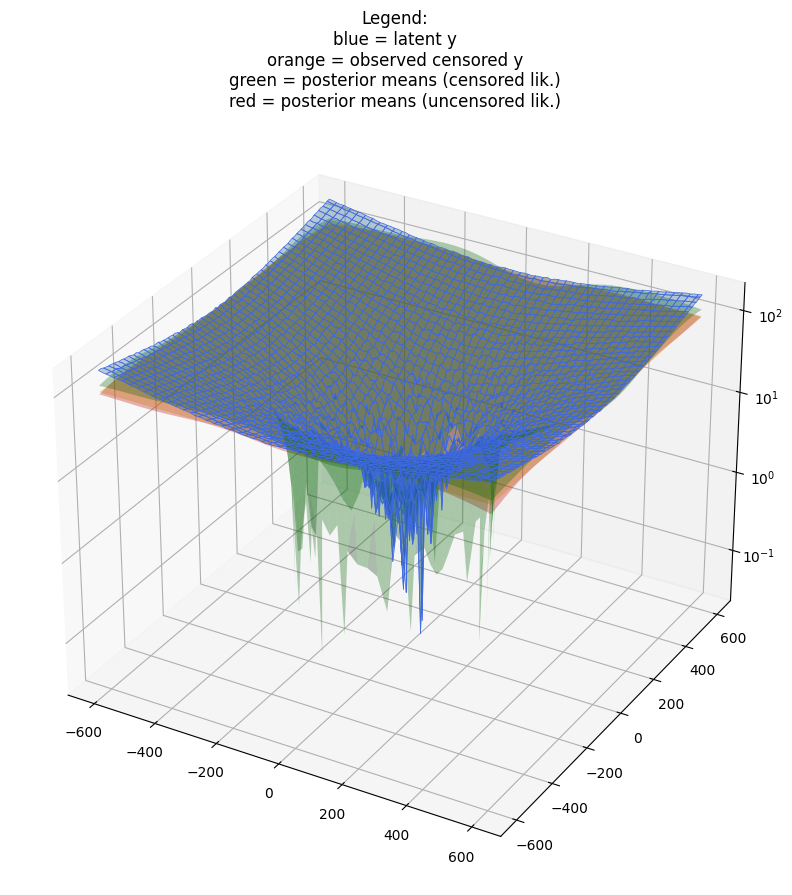

In [81]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')

def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"

# Plot the 3D surface
ax.plot_surface(x_test[:, 0].reshape((100, 100)), x_test[:, 1].reshape((100, 100)), np.log10(y_latent_test.reshape((100, 100))),
                edgecolor='royalblue', lw=0.5, rstride=2, cstride=2, label='latent y',
                alpha=0.3)
ax.plot_surface(x_test[:, 0].reshape((100, 100)), x_test[:, 1].reshape((100, 100)), np.log10(y_test.reshape((100, 100))),
                lw=0.5, rstride=2, cstride=2, label='observed censored y', color='orange',
                alpha=0.3)
ax.plot_surface(x_test[:, 0].reshape((100, 100)), x_test[:, 1].reshape((100, 100)), np.log10(censored_posterior_f.loc.detach().reshape((100, 100))),
                lw=0.5, rstride=2, cstride=2, label='posterior f (censored lik.)', color='green',
                alpha=0.3)
ax.plot_surface(x_test[:, 0].reshape((100, 100)), x_test[:, 1].reshape((100, 100)), np.log10(uncensored_posterior_f.loc.detach().reshape((100, 100))),
                lw=0.5, rstride=2, cstride=2, label='posterior f (uncensored lik.)', color='red',
                alpha=0.3)

ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.zaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.title("Legend:\nblue = latent y\norange = observed censored y\ngreen = posterior means (censored lik.)\nred = posterior means (uncensored lik.)")

Histograms of latents, targets, and posterior fits

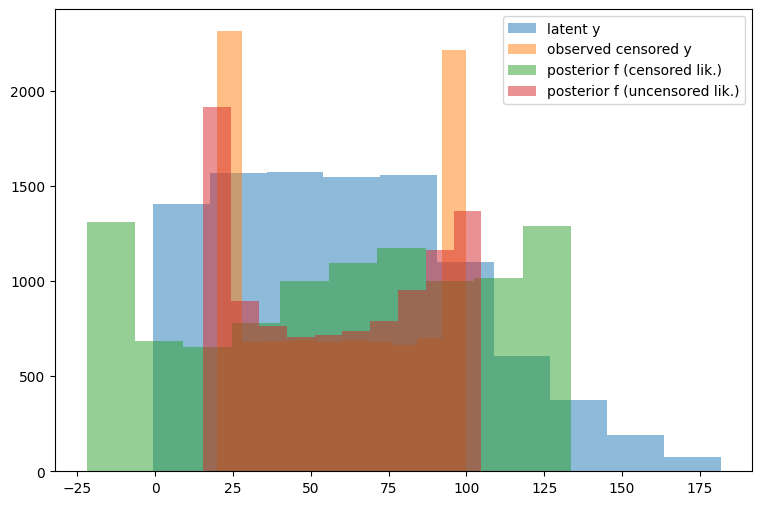

In [61]:
plt.figure(figsize=(9, 6))
plt.hist(y_latent_test, alpha=0.5, label='latent y')
plt.hist(y_test, alpha=0.5, label='observed censored y')
plt.hist(censored_posterior_f.loc.detach(), alpha=0.5, label='posterior f (censored lik.)')
plt.hist(uncensored_posterior_f.loc.detach(), alpha=0.5, label='posterior f (uncensored lik.)')
plt.legend()

# Synthetic Dataset 2: Beale

The dataset has a global minimum at x=(3, 0.5) at which point y=0

In [114]:
synthetic_test_fn = botorch.test_functions.synthetic.Beale(noise_std=1)

In [115]:
np.random.seed(1234)
x = np.random.uniform(low=-4.5, high=4.5, size=(100, 2))

In [116]:
x = torch.tensor(x, dtype=torch.float64)
y_latent = synthetic_test_fn(x)

In [117]:
MIN_VALUE, MAX_VALUE = 0.2804, 500.
y = y_latent.clone()
y[y > MAX_VALUE] = MAX_VALUE
y[y < MIN_VALUE] = MIN_VALUE
y

tensor([7.1261e+00, 4.1972e+01, 5.0000e+02, 5.0000e+02, 5.0000e+02, 3.6745e+01,
        2.1037e+02, 2.6290e+01, 9.4985e+00, 5.0000e+02, 1.3708e+01, 2.5944e+02,
        1.1198e+02, 1.7103e+02, 3.0951e+01, 1.4608e+01, 5.0000e+02, 2.0647e+02,
        5.0000e+02, 5.0000e+02, 5.0000e+02, 9.8383e+01, 6.9413e+00, 7.3900e+01,
        4.0675e+01, 1.7691e+01, 5.0000e+02, 5.0000e+02, 5.0000e+02, 5.0000e+02,
        8.0471e+00, 5.3049e+01, 5.0000e+02, 5.0000e+02, 5.0000e+02, 5.5764e+00,
        2.0792e+02, 5.0000e+02, 2.3386e+01, 5.0000e+02, 1.3006e+01, 3.4053e+01,
        5.0000e+02, 5.0000e+02, 4.2284e+00, 5.0571e+01, 4.1970e+02, 1.8396e+01,
        1.2963e+02, 6.6382e+01, 3.3769e+02, 2.8040e-01, 5.0000e+02, 3.7036e+01,
        5.0000e+02, 5.0000e+02, 3.1540e+02, 5.0000e+02, 5.0000e+02, 5.0000e+02,
        5.0000e+02, 6.9959e+00, 5.0000e+02, 1.0153e+00, 5.0000e+02, 2.1782e+01,
        5.0000e+02, 5.0000e+02, 5.0000e+02, 2.9850e+01, 5.0000e+02, 2.7959e+00,
        4.8728e+02, 5.0000e+02, 1.6090e+

In [118]:
x_test = np.meshgrid(np.linspace(-4.5, 4.5, 100), np.linspace(-4.5, 4.5, 100))
x_test = np.stack(x_test, axis=-1).reshape((-1, 2))

In [119]:
x_test = torch.FloatTensor(x_test)
y_latent_test = synthetic_test_fn(x_test)
y_test = y_latent_test.clone()
y_test[y_test > MAX_VALUE] = MAX_VALUE
y_test[y_test < MIN_VALUE] = MIN_VALUE

Plot histograms of uncensored and censored targets `y`

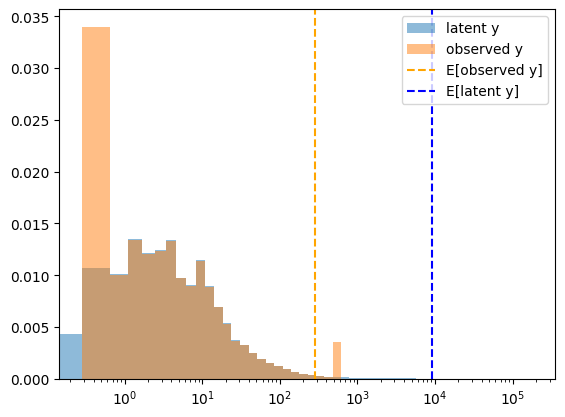

In [127]:
bins = 10**np.linspace(0, np.log10(y_latent_test.max()+1), num=50)-1
plt.hist(y_latent_test, alpha=0.5, label='latent y', density=True, bins=bins)
plt.hist(y_test, alpha=0.5, label='observed y', density=True, bins=bins)
plt.axvline(y_test.mean(), color='orange', linestyle='--', label='E[observed y]')
plt.axvline(y_latent_test.mean(), color='blue', linestyle='--', label='E[latent y]')
plt.xscale('log')
# plt.xticks(bins)
plt.legend()

MAE of predicting mean

In [121]:
(y_test - y_test.mean()).abs().mean()

tensor(214.5367)

## Censored Regressor

In [122]:
censored_model = GPModel(inducing_points=x, covariance_type='cholesky', kernel='matern', learn_inducing_locations=False, dtype=torch.float64)
censored_likelihood = CensoredGaussianLikelihoodAnalytic(low=MIN_VALUE, high=MAX_VALUE,
                                                         alpha=1., gamma=1., dzeta=1.)

if torch.cuda.is_available():
    x = x.cuda()
    y = y.cuda()
    censored_model = censored_model.cuda()
    censored_likelihood = censored_likelihood.cuda()

lmbd = 2 # lmbd in [1,10], 1 -> very linear, 10 -> very non-linear
kappa = 20 # kappa in [2,100], this is the signal to noise ratio. kappa = 2 -> signal = 2*noise
censored_model.covar_module.base_kernel.initialize(lengthscale=x.std()/lmbd)
censored_model.covar_module.initialize(outputscale=y.var());
censored_model.mean_module.initialize(constant=y.mean())
censored_likelihood.noise.initialize(noise=(y.std()/kappa).square());

censored_model.train()
censored_likelihood.train()
censored_model.train_inputs = (x,)
censored_model.train_targets = y
mll = gpytorch.mlls.VariationalELBO(censored_likelihood, censored_model, num_data=y.size(0))
# res = botorch.fit.fit_gpytorch_mll_torch(mll)
res = botorch.fit.fit_gpytorch_mll_scipy(mll)  #, options={'gtol': 1e-7, 'ftol': 1e-7})
print(res)


OptimizationResult(step=7927, fval=0.3989030580885216, status=<OptimizationStatus.SUCCESS: 2>, runtime=290.5353125490001, message='CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH')


### Evaluate on test data

In [123]:
censored_model.eval()
censored_likelihood.eval()
with gpytorch.settings.linalg_dtypes(torch.float64):
  with gpytorch.settings.num_likelihood_samples(200):
    censored_posterior_f = censored_model(x_test)
    # censored_posterior_y = censored_likelihood(censored_posterior_f)
# expected_y_pred = censored_posterior_y.sample_n(200).mean([0,1])
# print('MAE of training data (censored):', (expected_y_pred - y_test).abs().mean())
print('MAE of latent data:', (censored_posterior_f.loc - y_latent_test).abs().mean())

MAE of latent data: tensor(8972.3892, dtype=torch.float64, grad_fn=<MeanBackward0>)


## Uncensored Regressor

In [124]:
uncensored_model = GPModel(inducing_points=x, covariance_type='cholesky', dtype=torch.float64)
uncensored_model.covar_module.base_kernel.initialize(lengthscale=x.std()/lmbd)
uncensored_model.covar_module.initialize(outputscale=y.var());
uncensored_model.mean_module.initialize(constant=y.mean())
uncensored_likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_prior=gpytorch.priors.NormalPrior(loc=(y.std()/kappa).square(), scale=1))

if torch.cuda.is_available():
    uncensored_model = uncensored_model.cuda()
    uncensored_likelihood = uncensored_likelihood.cuda()


uncensored_model.train()
uncensored_likelihood.train()
uncensored_model.train_inputs = (x,)
uncensored_model.train_targets = y
uncensored_mll = gpytorch.mlls.VariationalELBO(uncensored_likelihood, uncensored_model, num_data=y.size(0))
uncensored_res = botorch.fit.fit_gpytorch_mll_scipy(uncensored_mll)
print(uncensored_res)

OptimizationResult(step=957, fval=6.356592964890153, status=<OptimizationStatus.SUCCESS: 2>, runtime=31.607710881000457, message='CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH')


### Evaluate on test data

In [125]:
uncensored_model.eval()
uncensored_likelihood.eval()

uncensored_posterior_f = uncensored_model(x_test)
uncensored_posterior_y = uncensored_likelihood(uncensored_posterior_f)

print('MAE of training data (censored):', (uncensored_posterior_y.loc - y_test).abs().mean())
print('MAE of latent data:', (uncensored_posterior_f.loc - y_latent_test).abs().mean())

MAE of training data (censored): tensor(66.4694, dtype=torch.float64, grad_fn=<MeanBackward0>)
MAE of latent data: tensor(9008.7047, dtype=torch.float64, grad_fn=<MeanBackward0>)


Scatter plots wrt latent `y`

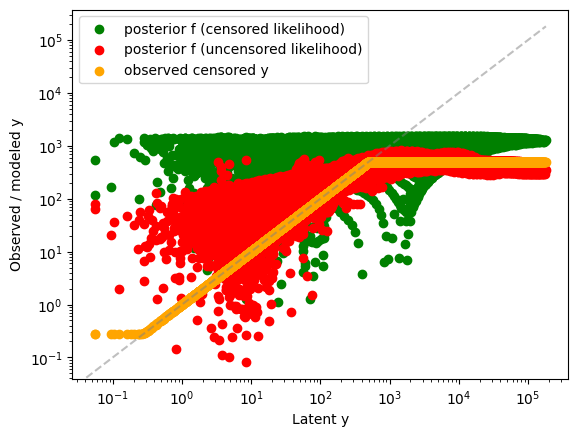

In [126]:
plt.scatter(y_latent_test.detach(), censored_posterior_f.loc.detach(), label='posterior f (censored likelihood)', color='green')
plt.scatter(y_latent_test.detach(), uncensored_posterior_f.loc.detach(), label='posterior f (uncensored likelihood)', color='red')
plt.scatter(y_latent_test.detach(), y_test.detach(), label='observed censored y', color='orange')
y_equals_x_grid = np.linspace(y_latent_test.min(), y_latent_test.max(), num=1000)
plt.plot(y_equals_x_grid, y_equals_x_grid, alpha=0.5, linestyle='--', color='grey')
plt.xlabel("Latent y")
plt.ylabel("Observed / modeled y")
plt.xscale('log')
plt.yscale('log')
plt.legend()

Function plots wrt x_0 and x_1

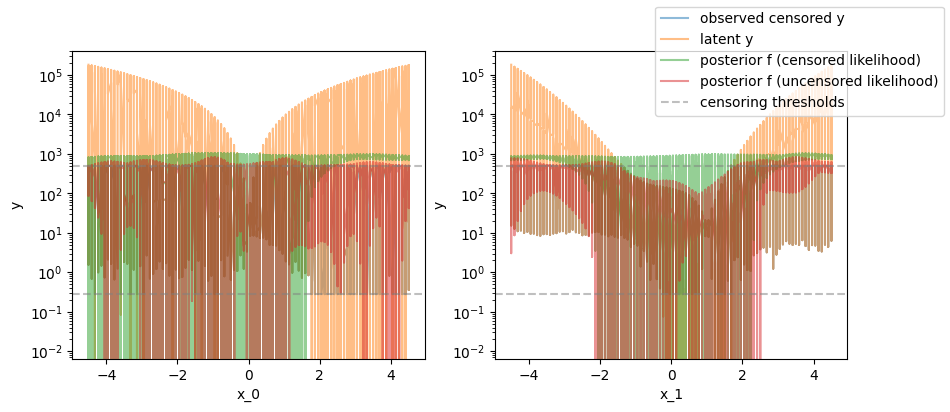

In [23]:
x_dims = x.shape[-1]
fig, axes = plt.subplots(ncols=x_dims, figsize=(5*x_dims, 4))
for i, ax in enumerate(axes):
  sorted_idx = np.argsort(x_test[:, i])
  x_grid = x_test[sorted_idx, i]
  ax.plot(x_grid, y_test[sorted_idx], label='observed censored y', alpha=0.5)
  ax.plot(x_grid, y_latent_test[sorted_idx], label='latent y', alpha=0.5)
  ax.plot(x_grid, censored_posterior_f.loc.detach()[sorted_idx], label='posterior f (censored likelihood)', alpha=0.5)
  ax.plot(x_grid, uncensored_posterior_f.loc.detach()[sorted_idx], label='posterior f (uncensored likelihood)', alpha=0.5)
  ax.axhline(MIN_VALUE, color='grey', linestyle='--', alpha=0.5)
  ax.axhline(MAX_VALUE, color='grey', linestyle='--', alpha=0.5, label='censoring thresholds')
  ax.set_xlabel('x_%d' % i)
  ax.set_ylabel('y')
  ax.set_yscale('log')
fig.legend(*ax.get_legend_handles_labels())

3D function plot

<ipython-input-31-621e0ee75802>:11: RuntimeWarning: invalid value encountered in log10
  ax.plot_surface(x_test[:, 0].reshape((100, 100)), x_test[:, 1].reshape((100, 100)), np.log10(y_latent_test.reshape((100, 100))),
<ipython-input-31-621e0ee75802>:17: RuntimeWarning: invalid value encountered in log10
  ax.plot_surface(x_test[:, 0].reshape((100, 100)), x_test[:, 1].reshape((100, 100)), np.log10(censored_posterior_f.loc.detach().reshape((100, 100))),
<ipython-input-31-621e0ee75802>:20: RuntimeWarning: invalid value encountered in log10
  ax.plot_surface(x_test[:, 0].reshape((100, 100)), x_test[:, 1].reshape((100, 100)), np.log10(uncensored_posterior_f.loc.detach().reshape((100, 100))),


(1.0, 5.0)

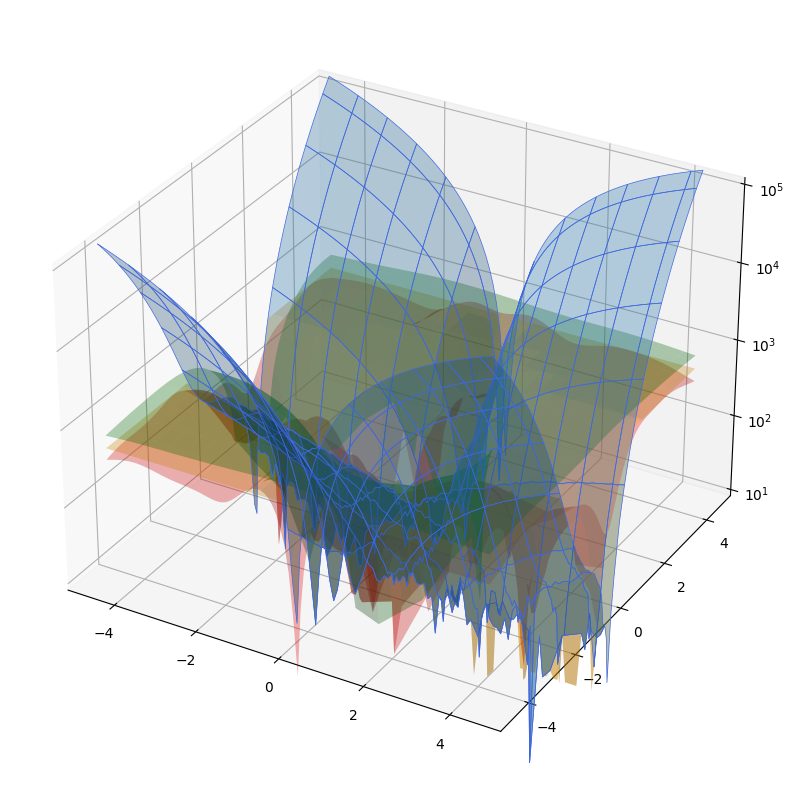

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')

def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"

# Plot the 3D surface
ax.plot_surface(x_test[:, 0].reshape((100, 100)), x_test[:, 1].reshape((100, 100)), np.log10(y_latent_test.reshape((100, 100))),
                edgecolor='royalblue', lw=0.5, rstride=8, cstride=8, label='latent y',
                alpha=0.3)
ax.plot_surface(x_test[:, 0].reshape((100, 100)), x_test[:, 1].reshape((100, 100)), np.log10(y_test.reshape((100, 100))),
                lw=0.5, rstride=8, cstride=8, label='observed censored y', color='orange',
                alpha=0.3)
ax.plot_surface(x_test[:, 0].reshape((100, 100)), x_test[:, 1].reshape((100, 100)), np.log10(censored_posterior_f.loc.detach().reshape((100, 100))),
                lw=0.5, rstride=8, cstride=8, label='posterior f (censored lik.)', color='green',
                alpha=0.3)
ax.plot_surface(x_test[:, 0].reshape((100, 100)), x_test[:, 1].reshape((100, 100)), np.log10(uncensored_posterior_f.loc.detach().reshape((100, 100))),
                lw=0.5, rstride=8, cstride=8, label='posterior f (uncensored lik.)', color='red',
                alpha=0.3)

ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
ax.zaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.set_zlim((1, 5))


Histograms of latents, targets, and posterior fits

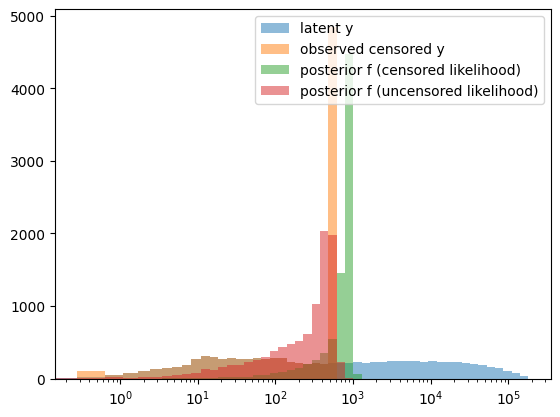

In [32]:
plt.hist(y_latent_test, alpha=0.5, label='latent y', bins=bins)
plt.hist(y_test, alpha=0.5, label='observed censored y', bins=bins)
plt.hist(censored_posterior_f.loc.detach(), alpha=0.5, label='posterior f (censored likelihood)', bins=bins)
plt.hist(uncensored_posterior_f.loc.detach(), alpha=0.5, label='posterior f (uncensored likelihood)', bins=bins)
plt.xscale('log')
plt.legend()